### Intro
Often, dealing with user data we have to face the fact that the data has no description. We don't have exact feature description and have only feature types instead (e.g. numeric, categorical, nominal). This is quite common in banking or HR - analytics, insurance, telecommunications, health care, retail or real estate. However, we have to be able to work with this type of data, conduct classical data analysis (e.g. descriptive data analysis and data visualization)

### Data Description
The data is presented by a french telecommunication company Orange. In the task we have to deal with personal information thus the data has been anonymized (i.e. any personal information that will allow identifying a person has been removed). There is no feature description, only their types (e.g. categorical, numeric). 

The dataset consists of 50k objects and includes 230 features. The first 190 features are numeric and the remaining 40 are categorical. This is the only information that we have.

### Project Objective
Create a model that will be capable of finding users that are prone to churn. If we know how to find these users in advance, we can effectively control the churn:
- Understand churn reasons
- Help users that prone to churn solve their problems
- Retain churn users (e.g. offer discounts or another more suitable and cheaper tariff)

In terms of Machine Learning, we are going to solve a binary classification task with labels `churn` and `not churn`

Firstly, let's start by looking at data and conduct initial data analysis

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as sts
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

Initial dataset consists of:
- The file with labels: `orange_small_churn_labels.train`
- The file with data: `orange_small_churn_labels.train`

In [94]:
# Download the data
data_train = pd.read_csv('orange_small_churn_data.txt')
data_labels = pd.read_csv('orange_small_churn_labels.txt', names=['is_churn'])

# Combine several dataframes into one 
data = pd.concat([data_train, data_labels], axis=1)
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,is_churn
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


-1    0.9256
 1    0.0744
Name: is_churn, dtype: float64


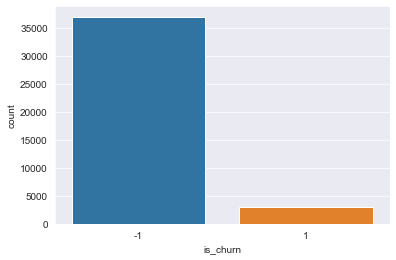

In [24]:
# Let's look at the class ratio 
print(data['is_churn'].value_counts()/data.shape[0])
sns.countplot(x=data['is_churn']);

As we can see from the `countplot` above, churn users is much less than non-churn users. It means that we are dealing with **class imbalance.**

Next, we are going to deal with features. It would be nice, if we could understand how features correlate with the target feature. We have to remember that we have two types of features:
- Numeric
- Categorical

Thus, we have to apply different methods for correlation analysis.

In [25]:
# Split the data according to their feature types 
target = data['is_churn']

num_features = data.iloc[:, :190]
cat_features = data.iloc[:, 190:-1]

Some features consist completely of missing values. Let's find them and drop.

In [26]:
# Select features consisting of only missing values 
num_feat_to_drop = [feature for feature in num_features.columns if num_features[feature].isna().all()]
cat_feat_to_drop = [feature for feature in cat_features.columns if cat_features[feature].isna().all()]

# Drop these features 
num_features.drop(columns=num_feat_to_drop, axis=1, inplace=True)
cat_features.drop(columns=cat_feat_to_drop, axis=1, inplace=True)

### Categorical Features Correlation with Target Feature 
For calculating this correlation, we are going to use `Crammer's V Value`. The method requires the absence of missing values, thus we will encode missing values into the category `unknown`.

In [27]:
# Substitute NaN values into category 'unknown'
for feature in cat_features.columns:
    cat_features[feature].fillna('unknown', inplace=True)

Besides, the method applies other criteria to the data:
- Number of observations in features `X1` and `X2` must be more or equal to 40 (`n >= 40`)
- Number of elements in a cell less than 5 must not exceed 20%

In [35]:
# Define a function for Crammer's V Value calculation
def calculate_crammer_coef(feature_df, target, correction=True, return_p_value=True, ascending=False):

    crammer_corrs = [] # for storing the calculated correlations
    
    for feature in feature_df.columns:
        confusion_matrix = pd.crosstab(feature_df[feature], target)
        n_observations = feature_df[feature].shape[0]
        n_rows, n_colmns = confusion_matrix.shape
        
        # Condition for confusion_matrix
        ratio = (np.sum((confusion_matrix.loc[:, -1] < 5)) + np.sum((confusion_matrix.loc[:, -1] < 5)))/confusion_matrix.size
        
        if ratio <= 0.2:
            # p-values option
            if return_p_value:
                chi2_res = sts.chi2_contingency(confusion_matrix, correction=correction)
                crammer_corrs.append((feature_df[feature].name, chi2_res[1], np.sqrt(chi2_res[0]/(n_observations*(min(n_rows, n_colmns)-1)))))
            else:
                chi2_val = sts.chi2_contingency(confusion_matrix, correction=correction)[0]
                crammer_corrs.append((feature_df[feature].name, np.sqrt(chi2_val/(n_observations*(min(n_rows, n_colmns)-1)))))
    
    return pd.DataFrame(crammer_corrs, columns=['Feature', 'p-value', 'V_Crammer_Value']).sort_values(by='V_Crammer_Value', ascending=ascending)

In [36]:
# Calculated Correlations
cat_feat_corrs = calculate_crammer_coef(feature_df=cat_features,
                                        target=target,
                                        ascending=False)
cat_feat_corrs

,Feature,p-value,V_Crammer_Value
12,Var218,1.156910e-90,0.101756
5,Var206,4.601789e-49,0.085054
19,Var228,7.244578e-33,0.075575
4,Var205,2.175743e-45,0.072558
3,Var204,9.189547e-08,0.069023
20,Var229,9.669562e-33,0.062485
6,Var207,1.429551e-22,0.058276
16,Var225,1.645757e-27,0.056515
18,Var227,2.666712e-24,0.055619
13,Var221,1.342547e-18,0.049119


Now we can somehow assume dependencies between categorical features and the target feature. Most of the features are significant except:
- `Var215, Var224, Var223, Var208`

I'd like to point out that some features are sparse (i.e. these features have many categories). **Sparse features are likely irrelevant for the classification.**

In [47]:
# We also have features that didn't pass the main condition of the method 
print('Original Number of Categorical Features: ', cat_features.shape[1])
print('Number of Categorical Features After V-Crammer: ', cat_feat_corrs.shape[0])

Original Number of Categorical Features:  38
Number of Categorical Features After V-Crammer:  21


In [38]:
# For instance, feature Var200 has many categories (13298), this is too many
cat_features.describe()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
count,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,...,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000
unique,2,355,50,4,23,4,221,3891,4401,13298,...,3891,7,3891,5,2,4,23,7,30,5
top,unknown,DHeq9ayfAo,RO12,unknown,taul,1K8T,0Xwj,fhk21Ss,r83_sZi,unknown,...,4UxGlow,oslk,catzS2D,LM8l689qOp,unknown,unknown,FSa2,RAYp,F2FyR07IdsN7I,unknown
freq,39129,313,28817,29810,38353,39633,3688,3557,746,20366,...,3557,29610,3557,29279,39338,20935,6403,28112,26211,22777


Let's look at the number of levels for categorical features that **passed the condition** of the `V-Crammer`

In [51]:
cat_features[cat_feat_corrs['Feature'].values].describe()

,Var218,Var206,Var228,Var205,Var204,Var229,Var207,Var225,Var227,Var221,...,Var226,Var211,Var194,Var201,Var213,Var191,Var208,Var223,Var224,Var215
count,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,...,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000
unique,3,22,30,4,100,5,14,4,7,7,...,23,2,4,3,2,2,3,5,2,2
top,cJvF,IYzP,F2FyR07IdsN7I,VpdQ,RVjC,unknown,me75fM6ugJ,unknown,RAYp,oslk,...,FSa2,L84s,unknown,unknown,unknown,unknown,kIsH,LM8l689qOp,unknown,unknown
freq,20253,13854,26211,25612,1464,22777,28047,20935,28112,29610,...,6403,32215,29810,29810,39110,39129,36823,29279,39338,39437


These features are not so sparse. Let's look at the histogramm for these features according to their class label `churn/not churn`

Wall time: 1.78 s


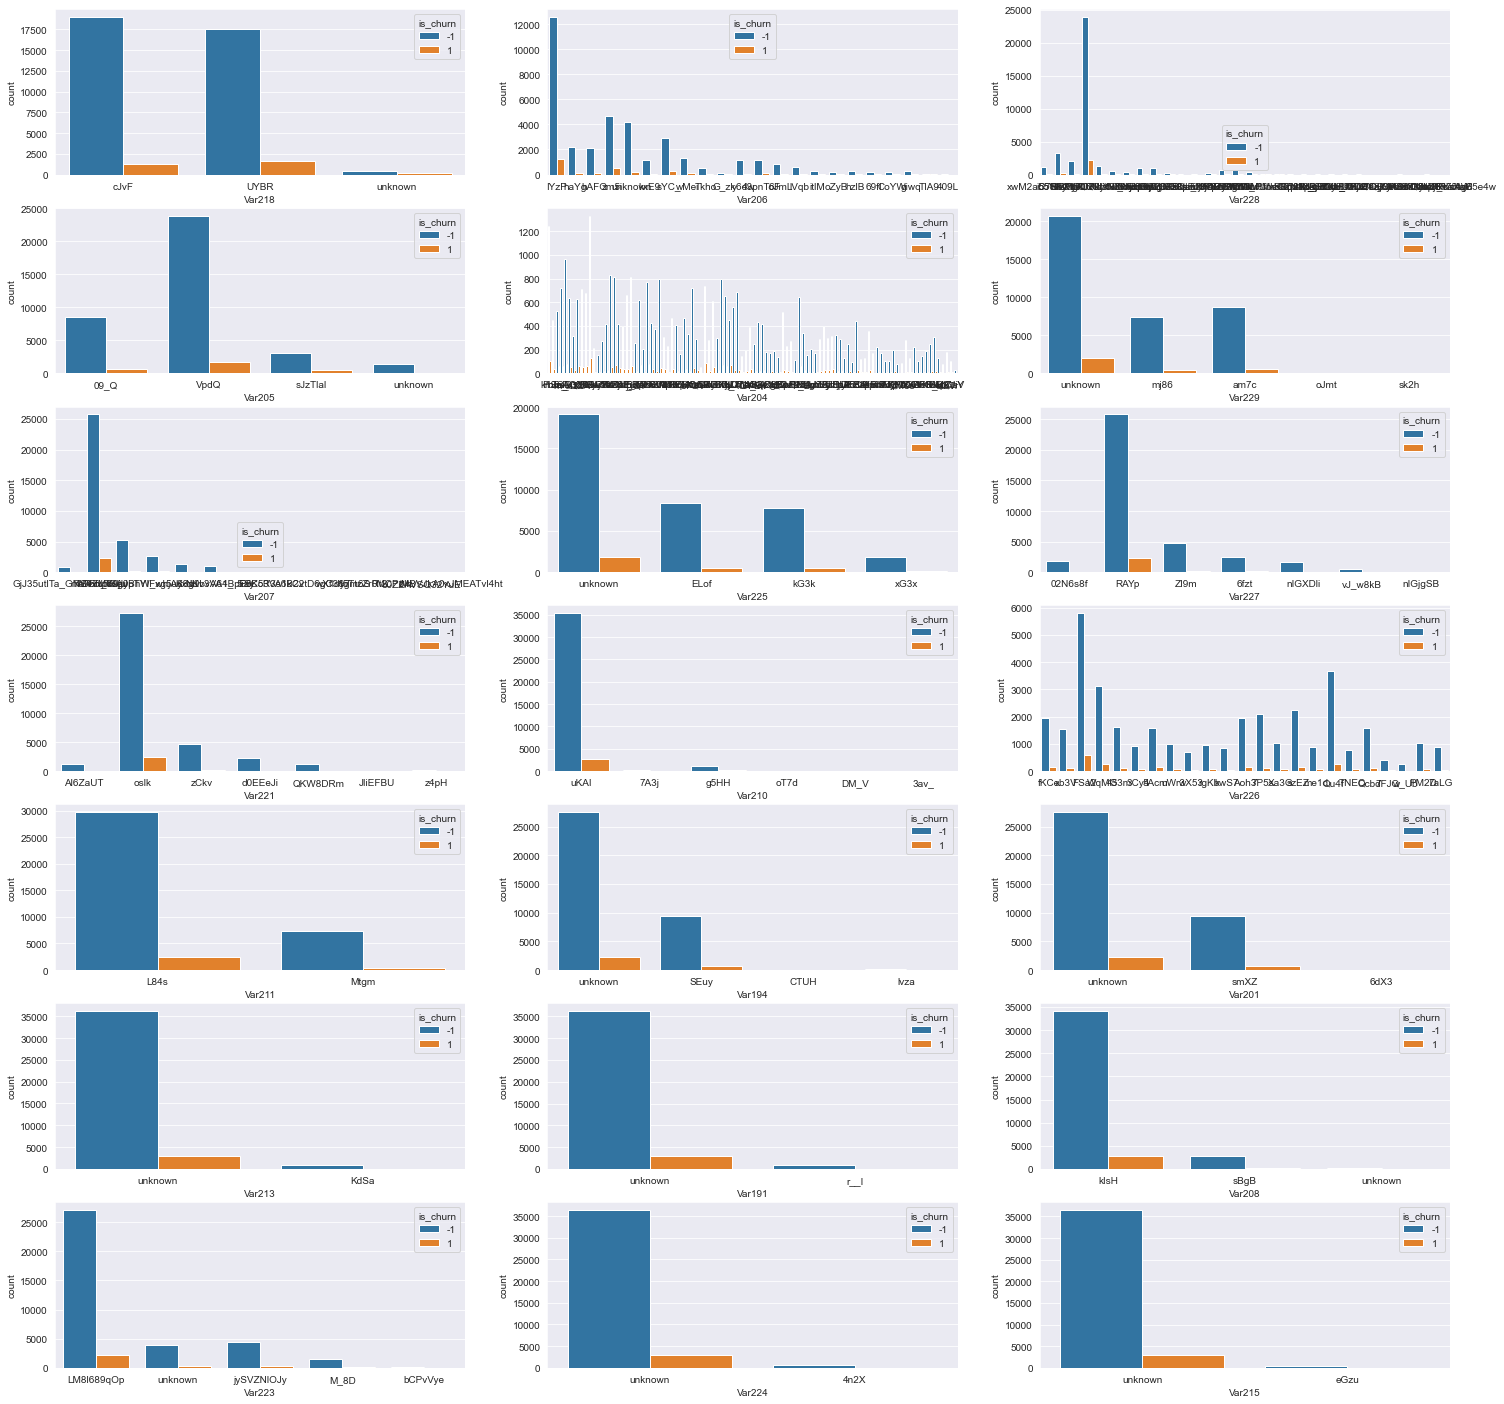

In [54]:
%%time

columns = cat_feat_corrs['Feature'].to_list() + ['is_churn']
cat_features['is_churn'] = target # needed for plots 

# Look at the histogram for selected features
fig, axes = plt.subplots(7, 3, figsize=(25, 25))
for indx, feature in enumerate(cat_features[columns].iloc[:, :-1]):
    sns.countplot(data=cat_features[columns], x=feature, hue='is_churn', ax=axes[indx // 3, indx % 3])
    
cat_features.drop('is_churn', axis=1, inplace=True)

We can see the groups that are likely for churn, for example, `Var227` has level `RAYp` in which we can observe the churn.

Let's analyze features that didn't meet the condition of `V-Crammer`. Perhaps, there are some dependencies in these features as well.

In [56]:
# Select these features and look at number of levels 
not_corr_features = cat_features[cat_features.columns.difference(cat_feat_corrs['Feature'])].columns
cat_features[not_corr_features].describe()

,Var192,Var193,Var195,Var196,Var197,Var198,Var199,Var200,Var202,Var203,Var212,Var214,Var216,Var217,Var219,Var220,Var222
count,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000
unique,355,50,23,4,221,3891,4401,13298,5543,6,78,13298,1819,12471,23,3891,3891
top,DHeq9ayfAo,RO12,taul,1K8T,0Xwj,fhk21Ss,r83_sZi,unknown,nyZz,9_Y1,NhsEn4L,unknown,mAjbk_S,unknown,FzaX,4UxGlow,catzS2D
freq,313,28817,38353,39633,3688,3557,746,20366,156,36192,23433,20366,3929,560,32191,3557,3557


These features are sparse and using `countplot` will be **uninformative.** However, there is a trick. We encode categories into numbers using `LabelEncoder` and then plot features distribution according to the class labels.

In [61]:
# In order not to substitute unknown into Nan again
not_corr_features_df = data[not_corr_features] # take from initial DF because we need NaN
mask = not_corr_features_df.isnull() # select NaNs (bool mask)

# Encode categories using LabelEncoder
not_corr_features_encoded = not_corr_features_df.astype(str).apply(LabelEncoder().fit_transform)

# Substitute 0 on NaN using where 
not_corr_features_encoded = not_corr_features_encoded.where(~mask, not_corr_features_df)
not_corr_features_encoded['is_churn'] = data['is_churn']

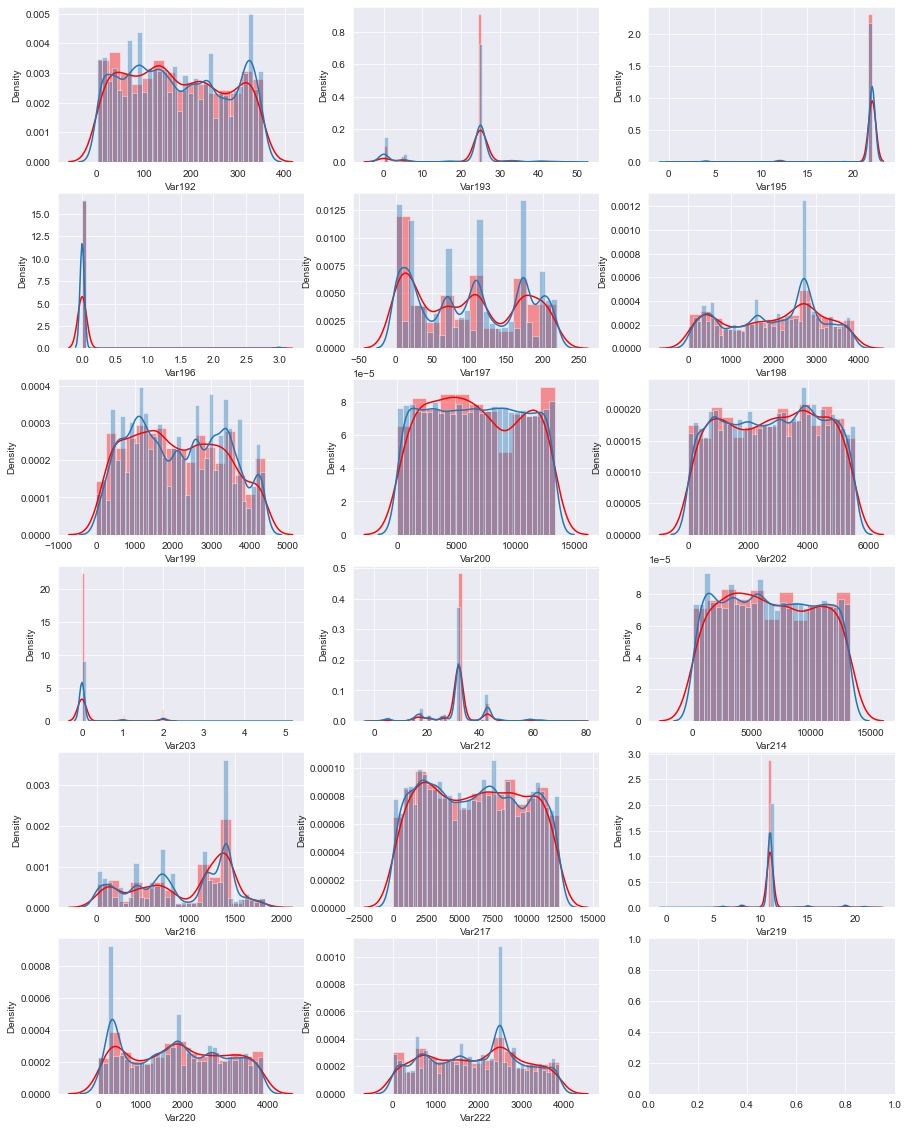

Wall time: 6.08 s


In [62]:
%%time

# Plotting the dependencies
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
for indx, feature in enumerate(not_corr_features_encoded.iloc[:, :-1].columns):
    sns.distplot(not_corr_features_encoded[not_corr_features_encoded['is_churn'] == 1][feature].dropna(), ax=axes[indx // 3, indx % 3], label='churn', color='r')
    sns.distplot(not_corr_features_encoded[not_corr_features_encoded['is_churn'] == -1][feature].dropna(), ax=axes[indx // 3, indx % 3], label='not_churn')
plt.show()

As we can see the distributions are mixed. Any interesting dependencies not found.

### Numeric Features Correlation with Target Feature 
For calculating this type of correlation, the following methods can be applied:
- Mathematical Expectation Difference for different class labels
- Point-Biserial Correlation

We are using the first option

In [67]:
# Define the function for Mathematical Exception Difference calculation
def math_exp_differences(feat_df, target, ascending=False):
    
    main_df = pd.concat([feat_df, target], axis=1) # for combining features with the target
    mat_exp_diff = [] # for storing the results
    
    for feature in feat_df.columns:
        group_means = main_df[[feature, target.name]].groupby(by=target.name).mean()
        means_diff = group_means.iloc[0, 0] - group_means.iloc[1, 0]
        
        mat_exp_diff.append(means_diff)
        
    df = abs(pd.DataFrame({'Corr_ME_diffs':mat_exp_diff}, index=feat_df.columns))

    return df.sort_values(by='Corr_ME_diffs', ascending=ascending)

In [70]:
mat_exp_corrs = math_exp_differences(feat_df=num_features,
                                     target=target,
                                     ascending=False)
mat_exp_corrs

,Corr_ME_diffs
Var131,1.034608e+07
Var69,4.808584e+05
Var53,4.389077e+05
Var177,4.017487e+05
Var180,3.201630e+05
...,...
Var2,5.181347e-03
Var173,5.087142e-03
Var44,3.251363e-03
Var138,1.639344e-03


Since we are interested in determing the features that cause the gratest impact on the target variable, we take the absolute values of obtained deviations. For now, it is not so important whether the feature *increase/decrease* leads to `churn/not churn`. The main idea is to determine the features that lead to this change.

To visualsie this change, we can use `BoxPlot`. For instance, let's take `Var111`. The more this feature, the more likely to be in churn group.

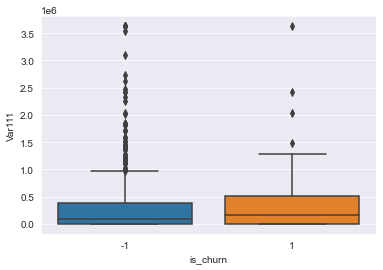

In [71]:
sns.boxplot(x=target, y=num_features['Var111']);

Since we have many numeric features, let's consider top-20 the most powerful features.

For these feature we plot the distribution according to their class labels.

In [73]:
# Select top-20 numeric features 
top_num_features = mat_exp_corrs.iloc[:20].index.to_list()

# For better visualization
columns = top_num_features + ['is_churn']
num_features['is_churn'] = target

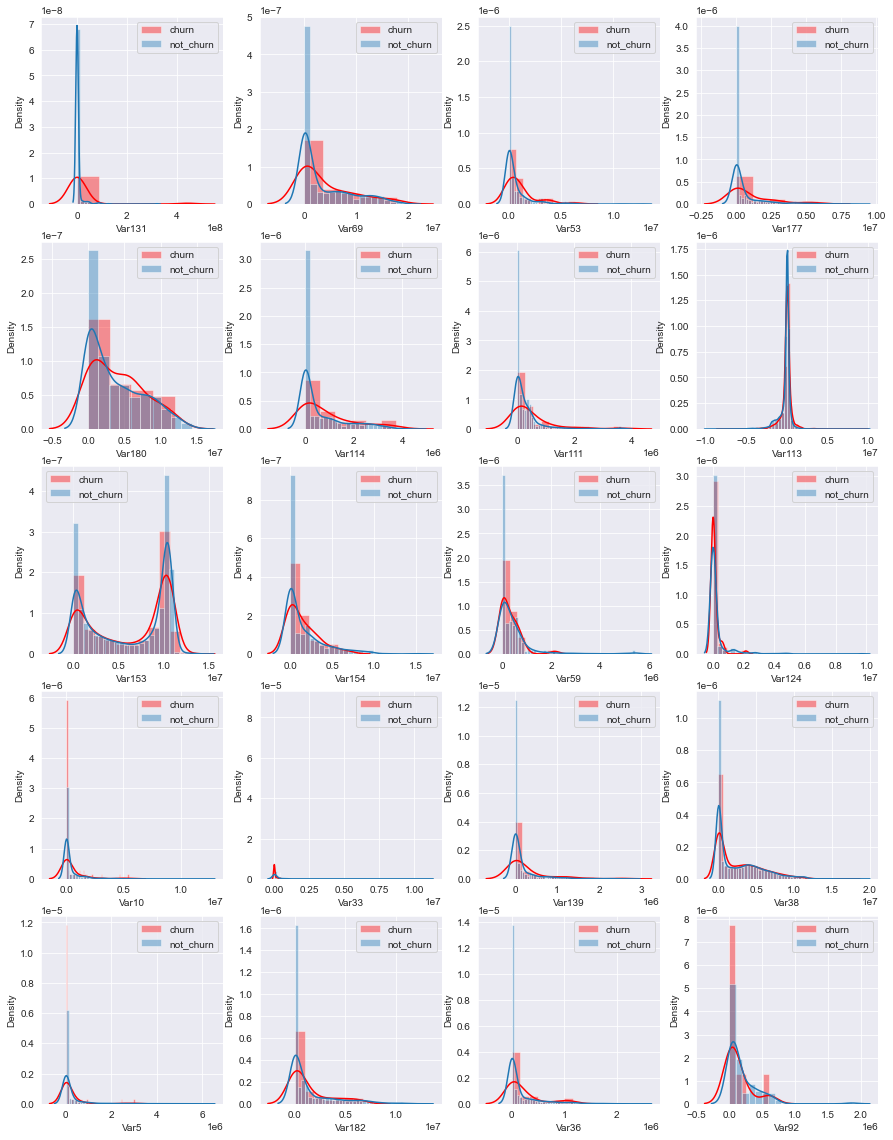

Wall time: 5.21 s


In [75]:
%%time

# Drop missing values and visualize
fig, axes = plt.subplots(5, 4, figsize=(15, 20))
for indx, feature in enumerate(num_features[columns].iloc[:, :-1]):
    sns.distplot(num_features[columns][num_features[columns]['is_churn'] == 1][feature].dropna(), ax=axes[indx // 4, indx % 4], label='churn', color='r')
    sns.distplot(num_features[columns][num_features[columns]['is_churn'] == -1][feature].dropna(), ax=axes[indx // 4, indx % 4], label='not_churn')
    axes[indx // 4, indx % 4].legend()
plt.show()

The distributions are mixed, but there are areas where they are slightly separable. Although it is difficult to talk about good separability here.

Besides, let's look at pairwise feature correlations.

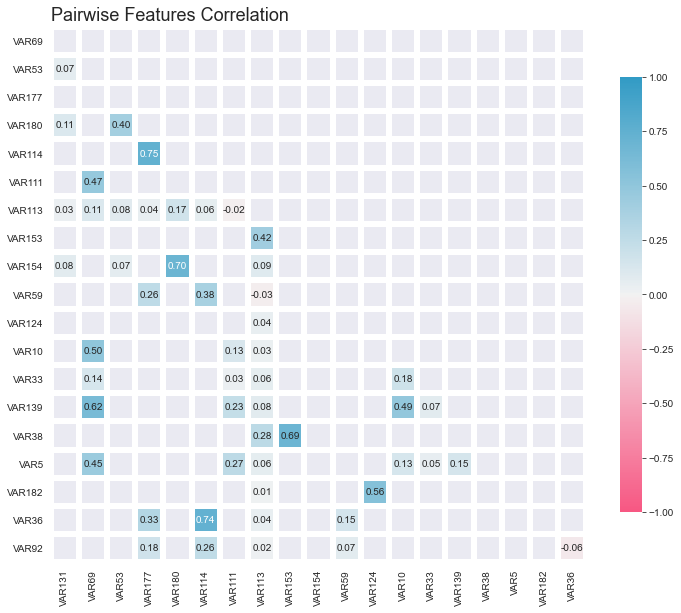

Wall time: 524 ms


In [78]:
%%time

# Define the function for plotting pairwise feature correlations
def make_btf_heatmap(df_corrs, title):
    fig, ax = plt.subplots(figsize=(12, 10))
    mask = np.triu(np.ones_like(df_corrs, dtype=np.bool))
    mask = mask[1:, :-1]
    corr = df_corrs.iloc[1:,:-1].copy()
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    sns.heatmap(corr,
                mask=mask, 
                annot=True,
                fmt=".2f",
                linewidths=5,
                cmap=cmap,
                vmin=-1,
                vmax=1, 
                cbar_kws={"shrink": .8},
                square=True)
    
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks)
    plt.title(title, loc='left', fontsize=18)
    plt.show()
    
make_btf_heatmap(num_features[top_num_features].corr(), title='Pairwise Features Correlation')

There are pairs of features that are correlated with each other
- `Var114/Var177: 0.75`
- `Var36/Var114: 0.74`
- `Var154/180: 0.7`
- `Var38/Var153: 0.69`

Perhaps, these features are identical and maybe it's a good idea to get rid of multicollinearity.

Next, let's conduct the same experiments but on top-20 less correlated features with the target. Maybe there are patterns there as well.

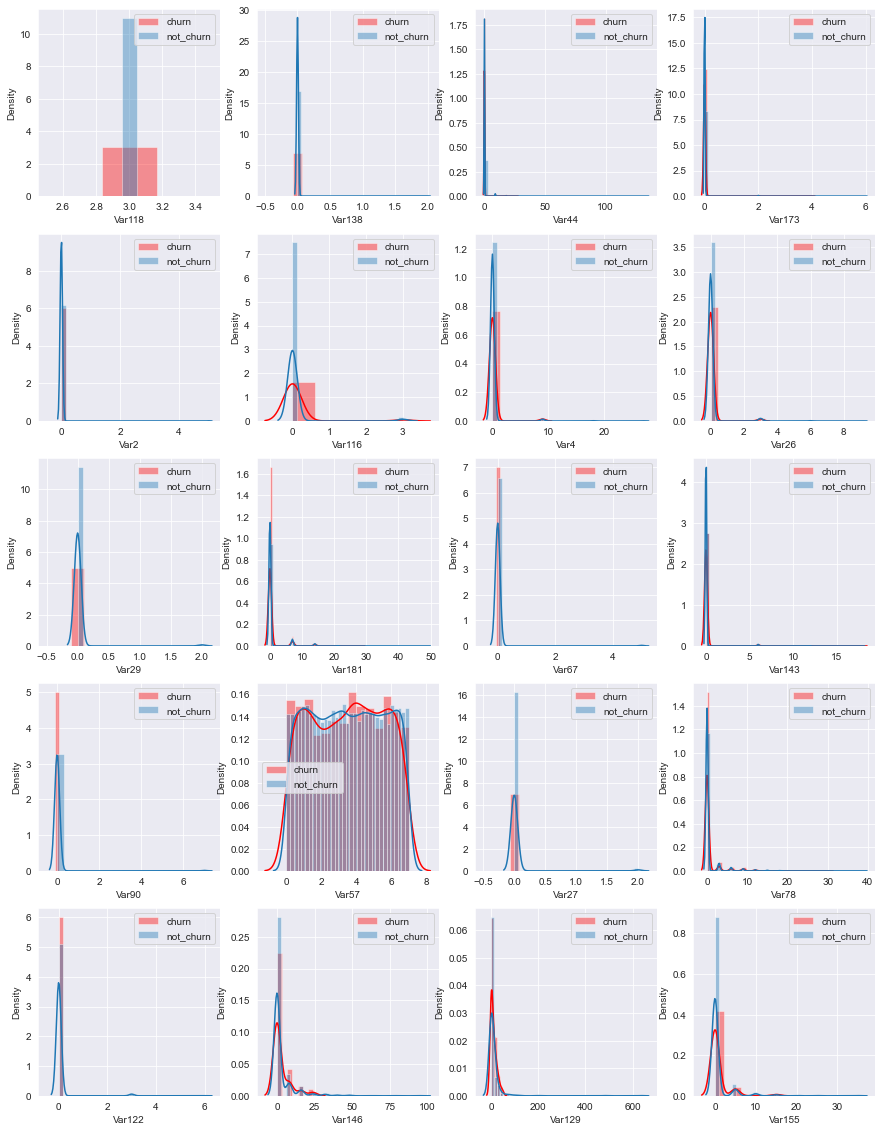

Wall time: 6.43 s


In [89]:
%%time

top_less_num_features = mat_exp_corrs['Corr_ME_diffs'].sort_values().index[:20]
columns = num_features[top_less_num_features].columns.to_list() + ['is_churn']

fig, axes = plt.subplots(5, 4, figsize=(15, 20))
for indx, feature in enumerate(num_features[columns].iloc[:, :-1]):
    sns.distplot(num_features[columns][num_features[columns]['is_churn'] == 1][feature].dropna(), ax=axes[indx // 4, indx % 4], label='churn', color='r')
    sns.distplot(num_features[columns][num_features[columns]['is_churn'] == -1][feature].dropna(), ax=axes[indx // 4, indx % 4], label='not_churn')
    axes[indx // 4, indx % 4].legend()
plt.show()

Maybe features `Var4, Var116` can be useful

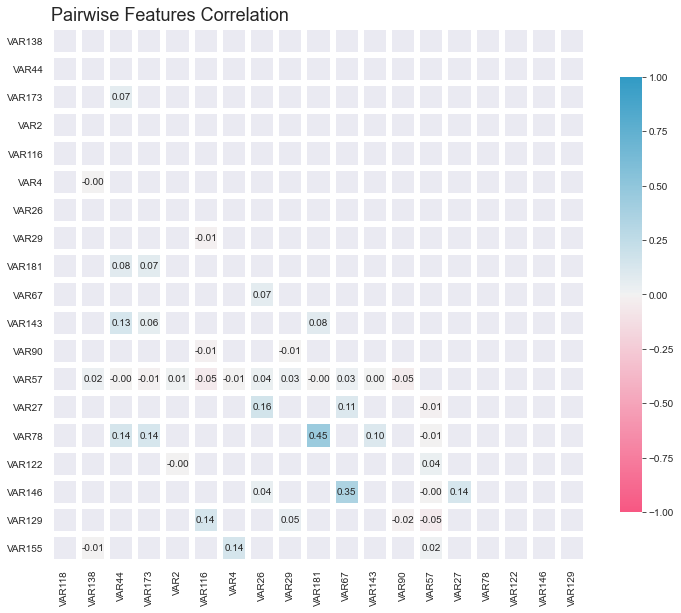

In [90]:
make_btf_heatmap(num_features[top_less_num_features].corr(), title='Pairwise Features Correlation')

Strong correlation between features not found 

In [ ]:
# Save the data 
df = pd.concat([num_features.drop('is_churn', axis=1), cat_features], axis=1)
df['is_churn'] = target

df.to_pickle('churn_processed.pkl')

### Result Analysis 
### Categorical Features 
Using the `V-Krammer` value allowed finding out a set of features that strongly correlate with the target feature. We have also found out that such features have not many levels (not sparse) and it's nice because they are meaningful and the model will be able to extract the dependencies.

Features that have a low correlation with the target are sparse (many levels: 500, 4k, 13k). These features are noisy.

### Numeric Features 
We have used mathematical expectation difference. Features that have a strong correlation with the target are correlated with each other what we cannot say for features with low correlation with the target.

This is only initial EDA and **more precise feature selection is needed.** We have many features and many missing values, thus without proper feature selection, it's impossible to go ahead.